# MODULE 2: Deep Neural Nets as Models of Human Cognition
## Part II: A modelling example (UMSI)

This notebook is part of the [CHI'22 Online Course on Cognitive Modeling](https://sites.google.com/view/modeling-chi22/home).

*Authors: Antti Oulasvirta, Andrew Howes, Jussi Jokinen*

### Source

Based on the [Jupyter notebook](https://github.com/diviz-mit/predimportance-public/blob/master/umsi_simple_inference_from_full_model.ipynb) by Fosco et al.:


> **Predicting Visual Importance Across Graphic Design Types** (2020). Camilo Fosco, Vincent Casser, Amish Kumar Bedi, Peter O’Donovan, Aaron Hertzmann, Zoya Bylinskii. *Proc. UIST 2020*. [Project homepage](https://predimportance.mit.edu)

### Learning objectives
After this block, you should be able to answer these four questions:
1. How to develop DNNs that can handle HCI-relevant inputs broadly and accurately?
2. How to exploit knowledge about human perception in the design and training of a neural architecture?
3. How to apply DNNs in HCI?
4. How to inspect the limits of a DNN model in order to come up with hypotheses for cognitive modeling? 



---

## 1. Model overview
**UMSI** is a DNN-based predictive model for HCI.The accronym stands for _Unified Model for Saliency and Importance_:
* **U**nified: Works with a broader range of diffent input types relevant in HCI.  
* **M**odel: Given an input image, predicts the regions users may look at. 
* **S**aliency: Predicts regions on display that are likely to attract attention. 
* **I**mportance: Predicts regions that users are likely to find visually important given the category of the image. For example, posters and GUIs are different in this respect.

![Model comparison](https://predimportance.mit.edu/images/header-vss.png)


### 1.1. What does the model do? 

The model does image-to-image prediction:
* **Input:** An image of a user interface, infographics, add or poster. [Examples](https://drive.google.com/uc?export=view&id=1cBhMZwBYqzQe5ked0TjY2I4dre2qImMb)
* **Output:** The input image overlaid with a heatmap denoting predicted visual importance. [Predictions for different terminals](https://drive.google.com/uc?export=view&id=1BK22xmaP6uurQvCKnTob9b2DxISaY31o) are provided.
* **Prediction:** Predicts average of visual importance reported by 249 crowdworders who were asked to annotate 1,000 images. 

### 1.2. Training dataset 

Aiming for higher generalizability than previous models, the authors collected a novel, more comprehensive dataset for training the model. The **IMP1K** dataset has 1) more image categories and 2) more participants than most prior work. This arguably increases the robustness of predictions. It makes it less likely to overfit to trivial aspects of an image (e.g., pixel, aspect ratio). 

The dataset includes 1,000 images from five image categories:
 1. infographics 
 2. webpages
 3. mobile UIs
 4. advertisements
 5. movie posters. 

249 crowdworkers used the [ImportAnnotsUI](https://github.com/turkeyes/importannots) to annotate the most visually important regions. The workers were
*''asked to annotate the most important regions. There are no definitions of what should be considered important. We restrict participants to a maximum of one minute per image.''* [Source: TurkEyes, CHI'20](http://turkeyes.mit.edu/documents/TurkEyes.pdf). 

### 1.3. Neural architecture 

Architectural choices exploit insights from both computer vision and studies of human vision:
* **Encoders**: UMSI extends Xception, which extracts basic image features in depthwise-separable convolutions. 
* **Atrous Separable Pyramid Pooling (ASPP)**: Uses parallel [dilated convolution](https://media.geeksforgeeks.org/wp-content/uploads/20210212153139/normalvsdilatedconv-660x333.png) layers. 
* **Decoder**: A set of convolutions followed by upsampling layers and dropout. Scales up feature maps to the original image size.
* **Classification**: A parallel convolution-based classification layer conditions output to the image category.

[UMSI architecture](https://drive.google.com/uc?export=view&id=1xC08Q7gEOAOly_CplIDwkGtAQSdQEVJ2)

### 1.4. Model training

To avoid overfitting, the model training procedure aimed at learning salient features *in general* and, after that, domain-specific aspects *in specific*:
1. Pre-train on SALICON (a large non-HCI dataset) to learn image features largely relevant to saliency. (General)
2.  Fine-tune on an HCI-specific dataset (e.g., IMP1K). Mix SALICON images to the fine-tuning data to prevent ''forgetting'' them. (Specific)
3. Loss function: KL divergence and CC (correlation coefficient) loss.

### 1.5. Model evaluation

The model achieved 0.98 accuracy in importance prediction on the IMP1K dataset.

* [Prediction examples](https://drive.google.com/uc?export=view&id=1BLZqshuV_yi0tjwplgvHCuzfOJ16cp1V)
* [Failure cases](https://drive.google.com/uc?export=view&id=1VWWHsBKdozGG_U8ZnW2tGO1U808z2IlF)

USMI exhibits some human-like tendencies in saliency, such as face bias. Human faces are likely to draw attention.

### 1.6. Applications in HCI

The model can be used to assess designs. If saliency is predicted to be low on an item that should have high saliency, one can algorithmically seek for a better spatial layout or recoloring. Example:
* [UI reflow example](https://drive.google.com/uc?export=view&id=13beZHg5fNLNwJ5enzwdAs3QGXqv-ezkw)


---

## 2. Preparations

### Step 1. Installing conda and importing packages

We need earlier versions of h5py and TensorFlow.

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)


In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import os
import keras.backend as K
from PIL import Image
import scipy
import skimage.transform as skit

print(keras.__version__)

Using TensorFlow backend.


2.3.1


### Step 2. Define auxiliary functions

In [3]:
# Define the input shape of the model
shape_r=240
shape_c=320

def padding(img, shape_r, shape_c, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)
    original_shape = np.asarray(img).shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = img.resize((new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = img.resize((shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded

def preprocess_images(paths, shape_r, shape_c, pad=True, show=False):
    if pad:
        ims = np.zeros((len(paths), shape_r, shape_c, 3))
    else:
        ims =[]

    for i, path in enumerate(paths):
        original_image = Image.open(path)
        if original_image is None:
            raise ValueError('Path unreadable: %s' % path)
        if pad:
            padded_image = padding(original_image, shape_r, shape_c, 3)
            ims[i] = padded_image
        else:
            original_image = original_image.astype(np.float32)
            original_image[..., 0] -= 103.939
            original_image[..., 1] -= 116.779
            original_image[..., 2] -= 123.68
            ims.append(original_image)
            ims = np.array(ims)
            print('ims.shape in preprocess_imgs',ims.shape)
            
        if show:
            print("Path:", path)
            plt.figure(figsize=[8,8])
            plt.subplot(1,2,1)
            plt.imshow(original_image)
            plt.title("Original image")
            plt.subplot(1,2,2)
            plt.imshow(padded_image)
            plt.title("Input to network")
            plt.show()

    if pad:
        ims[:, :, :, 0] -= 103.939
        ims[:, :, :, 1] -= 116.779
        ims[:, :, :, 2] -= 123.68

    return ims

def postprocess_predictions(pred, shape_r, shape_c, blur=False, normalize=False):
    predictions_shape = pred.shape
    rows_rate = shape_r / predictions_shape[0]
    cols_rate = shape_c / predictions_shape[1]

    if blur:
        sigma=blur
        pred = scipy.ndimage.filters.gaussian_filter(pred, sigma=sigma)

    if rows_rate > cols_rate:
        new_cols = (predictions_shape[1] * shape_r) // predictions_shape[0]
        pred = skit.resize(pred, (shape_r, new_cols))
        img = pred[:, ((pred.shape[1] - shape_c) // 2):((pred.shape[1] - shape_c) // 2 + shape_c)]
    else:
        new_rows = (predictions_shape[0] * shape_c) // predictions_shape[1]
        pred = skit.resize(pred, (new_rows, shape_c))
        img = pred[((pred.shape[0] - shape_r) // 2):((pred.shape[0] - shape_r) // 2 + shape_r), :]

    if normalize:
        img = img / np.max(img) * 255

    return img


def heatmap_overlay(im,heatmap,colmap='hot'):
    cm_array = cm.get_cmap(colmap)
    im_array = np.asarray(im)
    heatmap_norm = (heatmap-np.min(heatmap))/float(np.max(heatmap)-np.min(heatmap))
    heatmap_hot = cm_array(heatmap_norm)
    res_final = im_array.copy()
    heatmap_rep = np.repeat(heatmap_norm[:, :, np.newaxis], 3, axis=2)
    res_final[...] = heatmap_hot[...,0:3]*255.0*heatmap_rep + im_array[...]*(1-heatmap_rep)
    return res_final

### Step 3: Load pretrained model


**Alternative 1:** Manually upload the model weight file in [checkpoint format](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/checkpoint.ipynb) to the Colab folder:
1. Download the
[UMSI pretrained model](http://predimportance.mit.edu/data/xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5)
2. Open the folder panel on the left in Colab and navigate to "/content/".
3. Drag-and-drop the file to that folder.

**Alternative 2:** Use '!wget url'

In [4]:
# Alternative 2

!wget http://predimportance.mit.edu/data/xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5

# Note: in the Colab folder system, the downloaded .h5 file will appear in /content/

--2022-04-24 13:59:46--  http://predimportance.mit.edu/data/xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5
Resolving predimportance.mit.edu (predimportance.mit.edu)... 18.4.86.46
Connecting to predimportance.mit.edu (predimportance.mit.edu)|18.4.86.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120194112 (115M)
Saving to: ‘xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5’

xception_cl_fus_asp 100%[===================>] 114.63M  2.08MB/s    in 58s     

2022-04-24 14:00:46 (1.96 MB/s) - ‘xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5’ saved [120194112/120194112]



In [5]:
# Load the file

ckpt_path = '/content/xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5' 

model = keras.models.load_model(ckpt_path)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 159, 32) 0           block1_conv1_bn[0][0]            
__________

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


---

## 3. Model inspection

### In-class exercise

Let us inspect the model using the method of *visual analysis*. What kinds of inputs does it handle well and where does it err? What may cause these tendencies?

> **Task:** Inspect the model with realistic inputs and formulate hypotheses about the causes. In practice, you should find realistic input images and examine model predictions against empirically known effects (e.g., [a study on mobile saliency](https://dl.acm.org/doi/abs/10.1145/3379503.3403557)) or common sense (careful!). Formulate cognitive hypotheses *explaining* these findings. Refer to ''inductive biases'' in the model architecture. 

> **Answer template** (suggestive): ''When presented with [image], UMSI predicts that [what]. This tendency is because [explanation]. The model architecture favors [what]. This could be changed [if...].''  

### Step 1: Load images

In [6]:
# Load files for testing UMSI 
# Alternatively you can drag-and-drop images directly to /content/
#
# Notes: 
# - .JPG format
# - Should be cropped 
# - Just the UI; must not show anything extra (e.g. display bezel, finger, hand, ...)
# - Aspect ratio and resolution do not matter: padding and rescaling done automatically

!wget -O reddit.jpg https://img.ilcdn.fi/Cap9pJPP3InE7ECgfR6qoVh4NRI=/full-fit-in/612x0/img-s3.ilcdn.fi/7add7438c5e3b2f7442d520c74081e889deb20e0737570b2996811bc22ffbb9d.jpg
!wget -O iui.jpg https://pbs.twimg.com/media/EWEetUyX0AIoXo0?format=jpg&name=large
!wget -O windows11.jpg https://taitonetti.fi/image/catalog/blog/2021/win11-taskbar.jpg
!wget -O cluttered.jpg https://smarties2013.files.wordpress.com/2013/04/bad-userinterface1.jpg
!wget -O iphone.jpg https://i.redd.it/rt0azvng9ib81.jpg



--2022-04-24 14:01:30--  https://img.ilcdn.fi/Cap9pJPP3InE7ECgfR6qoVh4NRI=/full-fit-in/612x0/img-s3.ilcdn.fi/7add7438c5e3b2f7442d520c74081e889deb20e0737570b2996811bc22ffbb9d.jpg
Resolving img.ilcdn.fi (img.ilcdn.fi)... 13.32.80.25, 13.32.80.51, 13.32.80.9, ...
Connecting to img.ilcdn.fi (img.ilcdn.fi)|13.32.80.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45780 (45K) [image/jpeg]
Saving to: ‘reddit.jpg’

reddit.jpg          100%[===================>]  44.71K  --.-KB/s    in 0.02s   

2022-04-24 14:01:31 (2.41 MB/s) - ‘reddit.jpg’ saved [45780/45780]

--2022-04-24 14:01:31--  https://pbs.twimg.com/media/EWEetUyX0AIoXo0?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 146.75.36.159
Connecting to pbs.twimg.com (pbs.twimg.com)|146.75.36.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188528 (184K) [image/jpeg]
Saving to: ‘iui.jpg’

iui.jpg             100%[===================>] 184.11K  --.-KB/s    in 0.03s   

2022-04-24 14

In [7]:
# Update this line to include the files you want to test: 
img_paths = ['iui.jpg', 'reddit.jpg', 'windows11.jpg', 'cluttered.jpg', 'iphone.jpg']

### Step 2: Predict saliency maps

Path: iui.jpg


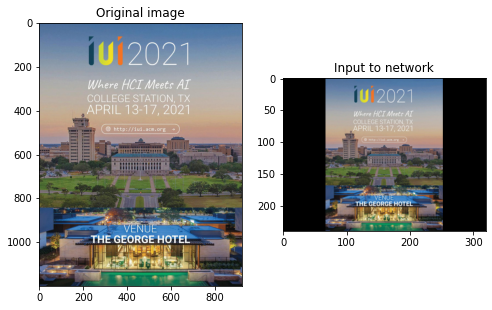

Path: reddit.jpg


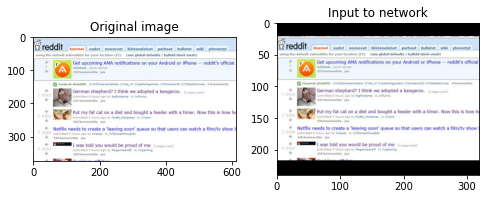

Path: windows11.jpg


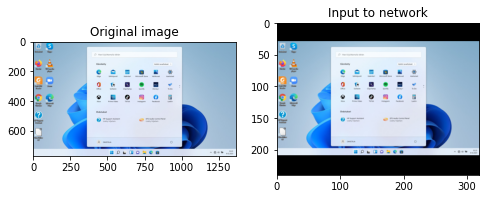

Path: cluttered.jpg


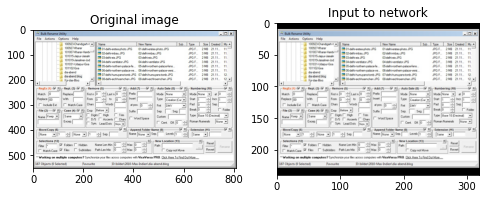

Path: iphone.jpg


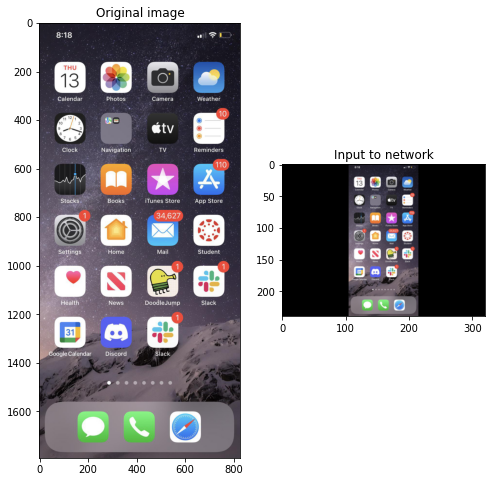

In [8]:
# preprocessing
img_batch = preprocess_images(img_paths, shape_r, shape_c, pad=True, show=True)

# compute predictions
pred = model.predict(img_batch)

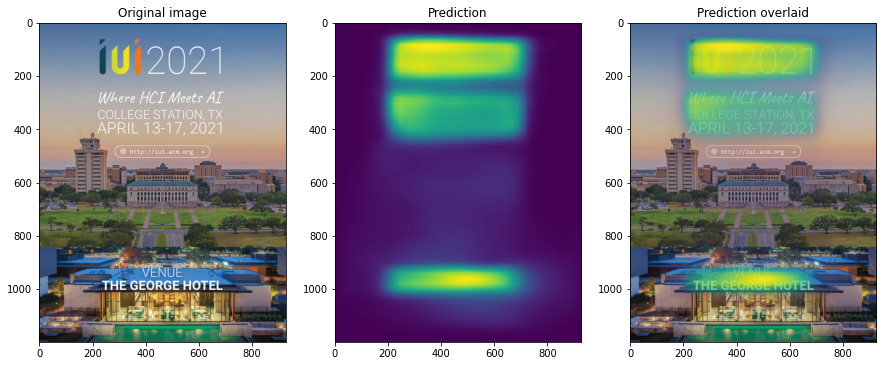

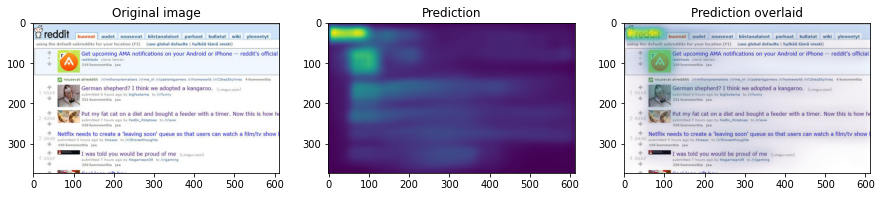

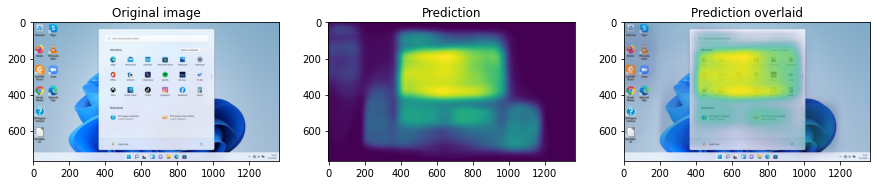

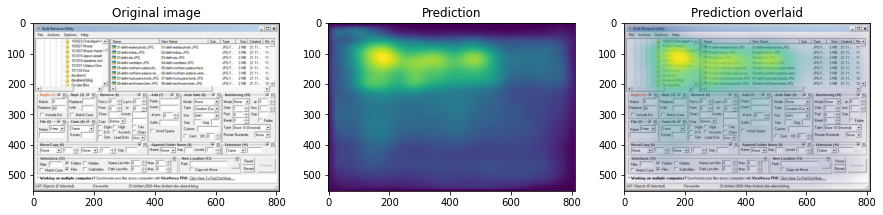

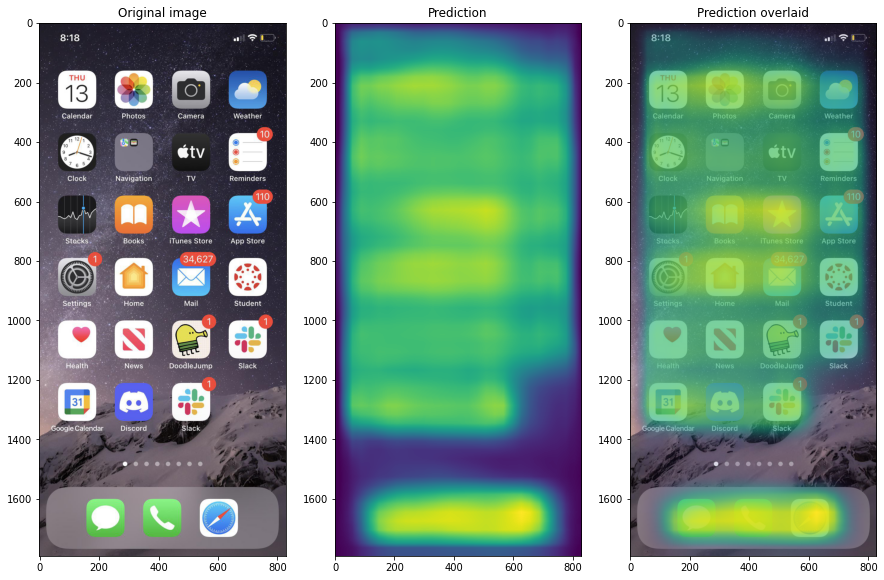

In [9]:
# plot results

k=3

pred_batch=[]
for i in range(len(img_paths)):
    
    # Open original image to get width and height
    im = Image.open(img_paths[i])
    width, height = im.size
    
    # Postprocess to get pred back to original size
    pred_batch.append(postprocess_predictions(pred[0][i,:,:,0], height, width))
    
    # Overlay heatmap on image
    res = heatmap_overlay(im,pred_batch[i],'viridis');
    
    # Show
    plt.figure(figsize=[15,15])
    plt.subplot(1,k,1)
    plt.imshow(im)
    plt.title("Original image")
    plt.subplot(1,k,2)
    plt.imshow(pred_batch[i])
    plt.title("Prediction")
    plt.subplot(1,k,3)
    plt.imshow(res)
    plt.title("Prediction overlaid")
    
    

---

## 4. Discussion

From a technical perspective, UMSI:
* Improves the accuracy of prediction over prior models
* Increases the scope of HCI-related stimuli that can be handled 
* Permits applications in UI design.

As a cognitive model, UMSI:
* Exploits convolution as a principle to process information hierarchically
* Exploits information bottlenecks (encoder--decoder structure) to enable dealing with large images.
* Exploits categorical side information to deal with different image categories.

The failure cases show room for improvement, especially with 
1. Semantically important, but visually unimportant areas, such as smaller headings, logos, or titles on cluttered backgrounds; 
2. Complex image structures (e.g., multiple cards)
3. Different stimulus environments are associated with different user tasks, leading to large differences in how users look at UIs.

The corresponding questions for cognitive modeling are: 
1. How do expectations about the image category bias attention to non-salient elements? How might users use such expectations to sample information to obtain most informative (not salient) aspects first?
2. How might complex images be parsed into a visual hierarchy in the visual system? Think: gestalts within gestalts. 
3. How can we provide information about a user's task to a neural network model?

## Takeways from this block

1. **Applying DNNs to HCI tasks:** You can improve the applicability of a DNN-based model to your HCI task by 
 1. collecting a more diverse and representative real-world dataset. Popular training datasets in ML often have little overlap with the needs of HCI applications;
 2. exploiting insights from human cognition as ''inductive biases'' in the desing of your neural architecture;
 3. training your model in a way that favors generalizability over domain specialization.

2. **Cognitive theory and DNN models:** Neural architectures can exploit theoretical knowledge about human perception. For example, 
 1. convolution implements a human-like representation of features that is positional (grids) and hierarhical (pyramid);
 2. encoder--decoder architectures allow learning a lower-dimensional representation of inputs. This allows you to scale up image sizes;
 3. categorical side information helps neural networks deal with diverse inputs that come from different contexts.

3. **Model applications:** DNNs can be used in HCI applications to
 1. evaluate designs based on their visual appearance;
 2. suggest improvements, when combined with computational design algorithms

4. **Model validation:** When building DNNs as models of human cognition, they need to be validated against human data:
 1. Behavioral ground truth data from diverse set of conditions and users;
 2. Cognitive of physiological ground truth data for testing elementary modeling choices (almost never done in HCI).

Note: Regular cross-validation practices may 'leak' information from individual users or designs into training set. 
